# PROJECT - **Unsupervised Anamoly Detection**

---
## DATASET - **Healthcare Providers Data For Anomaly Detection**

---
### NAME - **Shrikar Gaikar**

Mount Google Drive

In [1]:
# Mounting Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Dependencies

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

Data Loading and Initial Exploration

In [3]:
# Loading the dataset
data = pd.read_csv("/content/drive/MyDrive/Datasets/Healthcare Providers.csv")
data.head()

index  National Provider Identifier  \
0  8774979                    1891106191   
1  3354385                    1346202256   
2  3001884                    1306820956   
3  7594822                    1770523540   
4   746159                    1073627758   

  Last Name/Organization Name of the Provider First Name of the Provider  \
0                                 UPADHYAYULA                  SATYASREE   
1                                       JONES                      WENDY   
2                                    DUROCHER                    RICHARD   
3                                     FULLARD                     JASPER   
4                                    PERROTTI                    ANTHONY   

  Middle Initial of the Provider Credentials of the Provider  \
0                            NaN                        M.D.   
1                              P                        M.D.   
2                              W                         DPM   
3                            NaN                          MD   
4                              E                          DO   

  Gender of the Provider Entity Type of the Provider  \
0                      F                           I   
1                      F                           I   
2                      M                           I   
3                      M                           I   
4                      M                           I   

  Street Address 1 of the Provider Street Address 2 of the Provider  ...  \
0                1402 S GRAND BLVD                   FDT 14TH FLOOR  ...   
1                  2950 VILLAGE DR                              NaN  ...   
2                20 WASHINGTON AVE                          STE 212  ...   
3               5746 N BROADWAY ST                              NaN  ...   
4                 875 MILITARY TRL                        SUITE 200  ...   

  HCPCS Code                                  HCPCS Description  \
0      99223  Initial hospital inpatient care, typically 70 ...   
1      G0202  Screening mammography, bilateral (2-view study...   
2      99348  Established patient home visit, typically 25 m...   
3      81002                            Urinalysis, manual test   
4      96372  Injection beneath the skin or into muscle for ...   

  HCPCS Drug Indicator Number of Services Number of Medicare Beneficiaries  \
0                    N                 27                               24   
1                    N                175                              175   
2                    N                 32                               13   
3                    N                 20                               18   
4                    N                 33                               24   

  Number of Distinct Medicare Beneficiary/Per Day Services  \
0                                                 27         
1                                                175         
2                                                 32         
3                                                 20         
4                                                 31         

  Average Medicare Allowed Amount Average Submitted Charge Amount  \
0                    200.58777778                    305.21111111   
1                          123.73                           548.8   
2                           90.65                             155   
3                             3.5                               5   
4                           26.52                              40   

  Average Medicare Payment Amount Average Medicare Standardized Amount  
0                    157.26222222                         160.90888889  
1                          118.83                         135.31525714  
2                      64.4396875                           60.5959375  
3                            3.43                                 3.43  
4                    19.539393939                         19.057575758  

[5 ro

In [4]:
# Display the first few rows and check the structure
print(data.head())
print(data.info())

     index  National Provider Identifier  \
0  8774979                    1891106191   
1  3354385                    1346202256   
2  3001884                    1306820956   
3  7594822                    1770523540   
4   746159                    1073627758   

  Last Name/Organization Name of the Provider First Name of the Provider  \
0                                 UPADHYAYULA                  SATYASREE   
1                                       JONES                      WENDY   
2                                    DUROCHER                    RICHARD   
3                                     FULLARD                     JASPER   
4                                    PERROTTI                    ANTHONY   

  Middle Initial of the Provider Credentials of the Provider  \
0                            NaN                        M.D.   
1                              P                        M.D.   
2                              W                         DPM   
3                     

#### Data Preprocessing

Merging Name Columns and Uniform Format for Credentials

In [5]:
# Merge name columns into a single column 'Full Name'
data['Full Name'] = data['First Name of the Provider'].fillna('') + ' ' + \
                   data['Middle Initial of the Provider'].fillna('') + ' ' + \
                   data['Last Name/Organization Name of the Provider'].fillna('')
data['Full Name'] = data['Full Name'].str.strip()

# Drop original name columns
data = data.drop(columns=['Last Name/Organization Name of the Provider',
                          'First Name of the Provider',
                          'Middle Initial of the Provider'])

# Uniform format of credentials
data['Credentials of the Provider'] = data['Credentials of the Provider'].str.replace(r'\.', '', regex=True).str.upper()

Converting Object to Numeric

In [6]:
# Convert numeric columns to float64
numeric_columns = [
    'Number of Services',
    'Number of Medicare Beneficiaries',
    'Number of Distinct Medicare Beneficiary/Per Day Services',
    'Average Medicare Allowed Amount',
    'Average Submitted Charge Amount',
    'Average Medicare Payment Amount',
    'Average Medicare Standardized Amount'
]
for column in numeric_columns:
    data[column] = pd.to_numeric(data[column], errors='coerce')

# Imputation of missing numeric values with mean
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

Imputation of Categorical Missing Values

In [7]:
# Imputation of categorical missing values with mode
categorical_columns = ['Credentials of the Provider',
                       'Gender of the Provider',
                       'City of the Provider',
                       'State Code of the Provider',
                       'Provider Type']

for column in categorical_columns:
    data[column].fillna(data[column].mode()[0], inplace=True)

Frequency Encoding for Categorical Variables

In [8]:
# Frequency encoding for categorical variables
def frequency_encode(df, columns):
    for column in columns:
        freq_encoding = df[column].value_counts() / len(df)
        new_column_name = column + '_Freq'
        if new_column_name not in df.columns:
            df.insert(df.columns.get_loc(column) + 1, new_column_name, df[column].map(freq_encoding))
    return df

columns_to_encode = ['Credentials of the Provider',
                     'Gender of the Provider',
                     'Provider Type',
                     'State Code of the Provider']

data = frequency_encode(data, columns_to_encode)

Standardization of Numeric Columns

In [9]:
# Standardization of numeric columns
standardization_columns = [
    'Number of Services',
    'Number of Medicare Beneficiaries',
    'Number of Distinct Medicare Beneficiary/Per Day Services',
    'Average Medicare Allowed Amount',
    'Average Submitted Charge Amount',
    'Average Medicare Payment Amount',
    'Average Medicare Standardized Amount',
    'Credentials of the Provider_Freq',
    'Gender of the Provider_Freq',
    'State Code of the Provider_Freq'
]

standard_scaler = StandardScaler()
data[standardization_columns] = standard_scaler.fit_transform(data[standardization_columns])

# Make a copy for later use
data_copy = data.copy()

Principal Component Analysis (PCA)

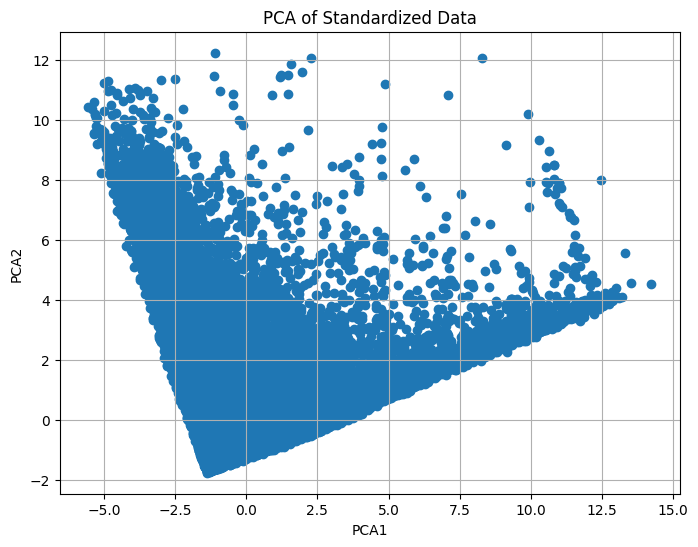

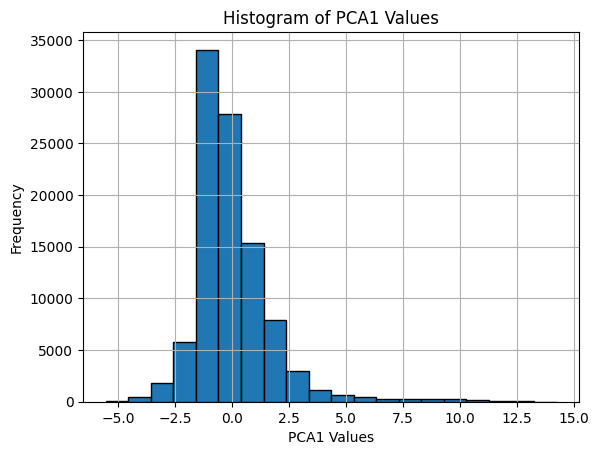

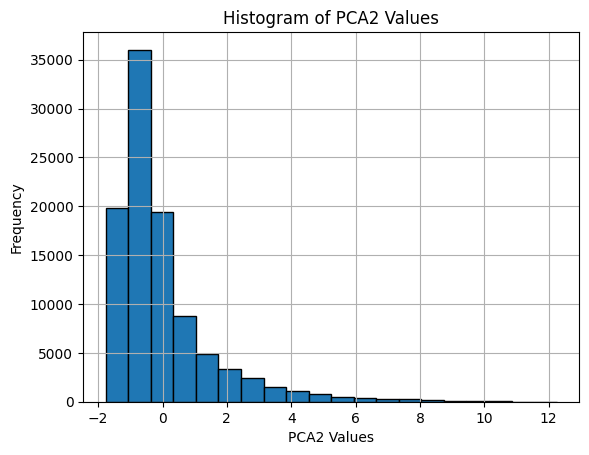

In [10]:
# Copy the standardized data for PCA
pca_data = data[standardization_columns].copy()

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_data)

# DataFrame of PCA results
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])

# Scatter plot of PCA1 and PCA2
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA of Standardized Data')
plt.grid(True)
plt.show()

# Plot PCA1 as a histogram
plt.hist(pca_df['PCA1'], bins=20, edgecolor='black')
plt.xlabel('PCA1 Values')
plt.ylabel('Frequency')
plt.title('Histogram of PCA1 Values')
plt.grid(True)
plt.show()

# Plot PCA2 as a histogram
plt.hist(pca_df['PCA2'], bins=20, edgecolor='black')
plt.xlabel('PCA2 Values')
plt.ylabel('Frequency')
plt.title('Histogram of PCA2 Values')
plt.grid(True)
plt.show()

### Clustering

K-Means Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


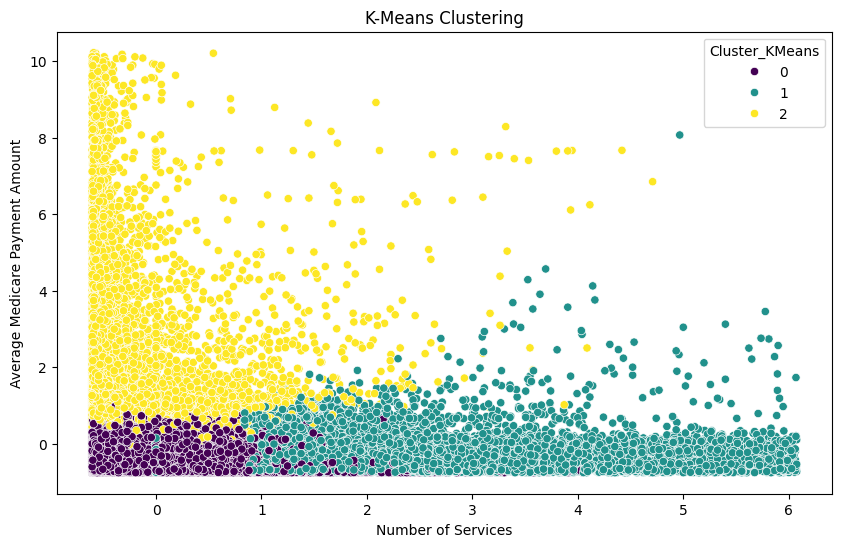

In [11]:
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster_KMeans'] = kmeans.fit_predict(data[numeric_columns])

# Visualize K-Means clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Number of Services', y='Average Medicare Payment Amount',
                hue='Cluster_KMeans', palette='viridis', legend='full')
plt.title('K-Means Clustering')
plt.show()

Algo plot of K-Means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

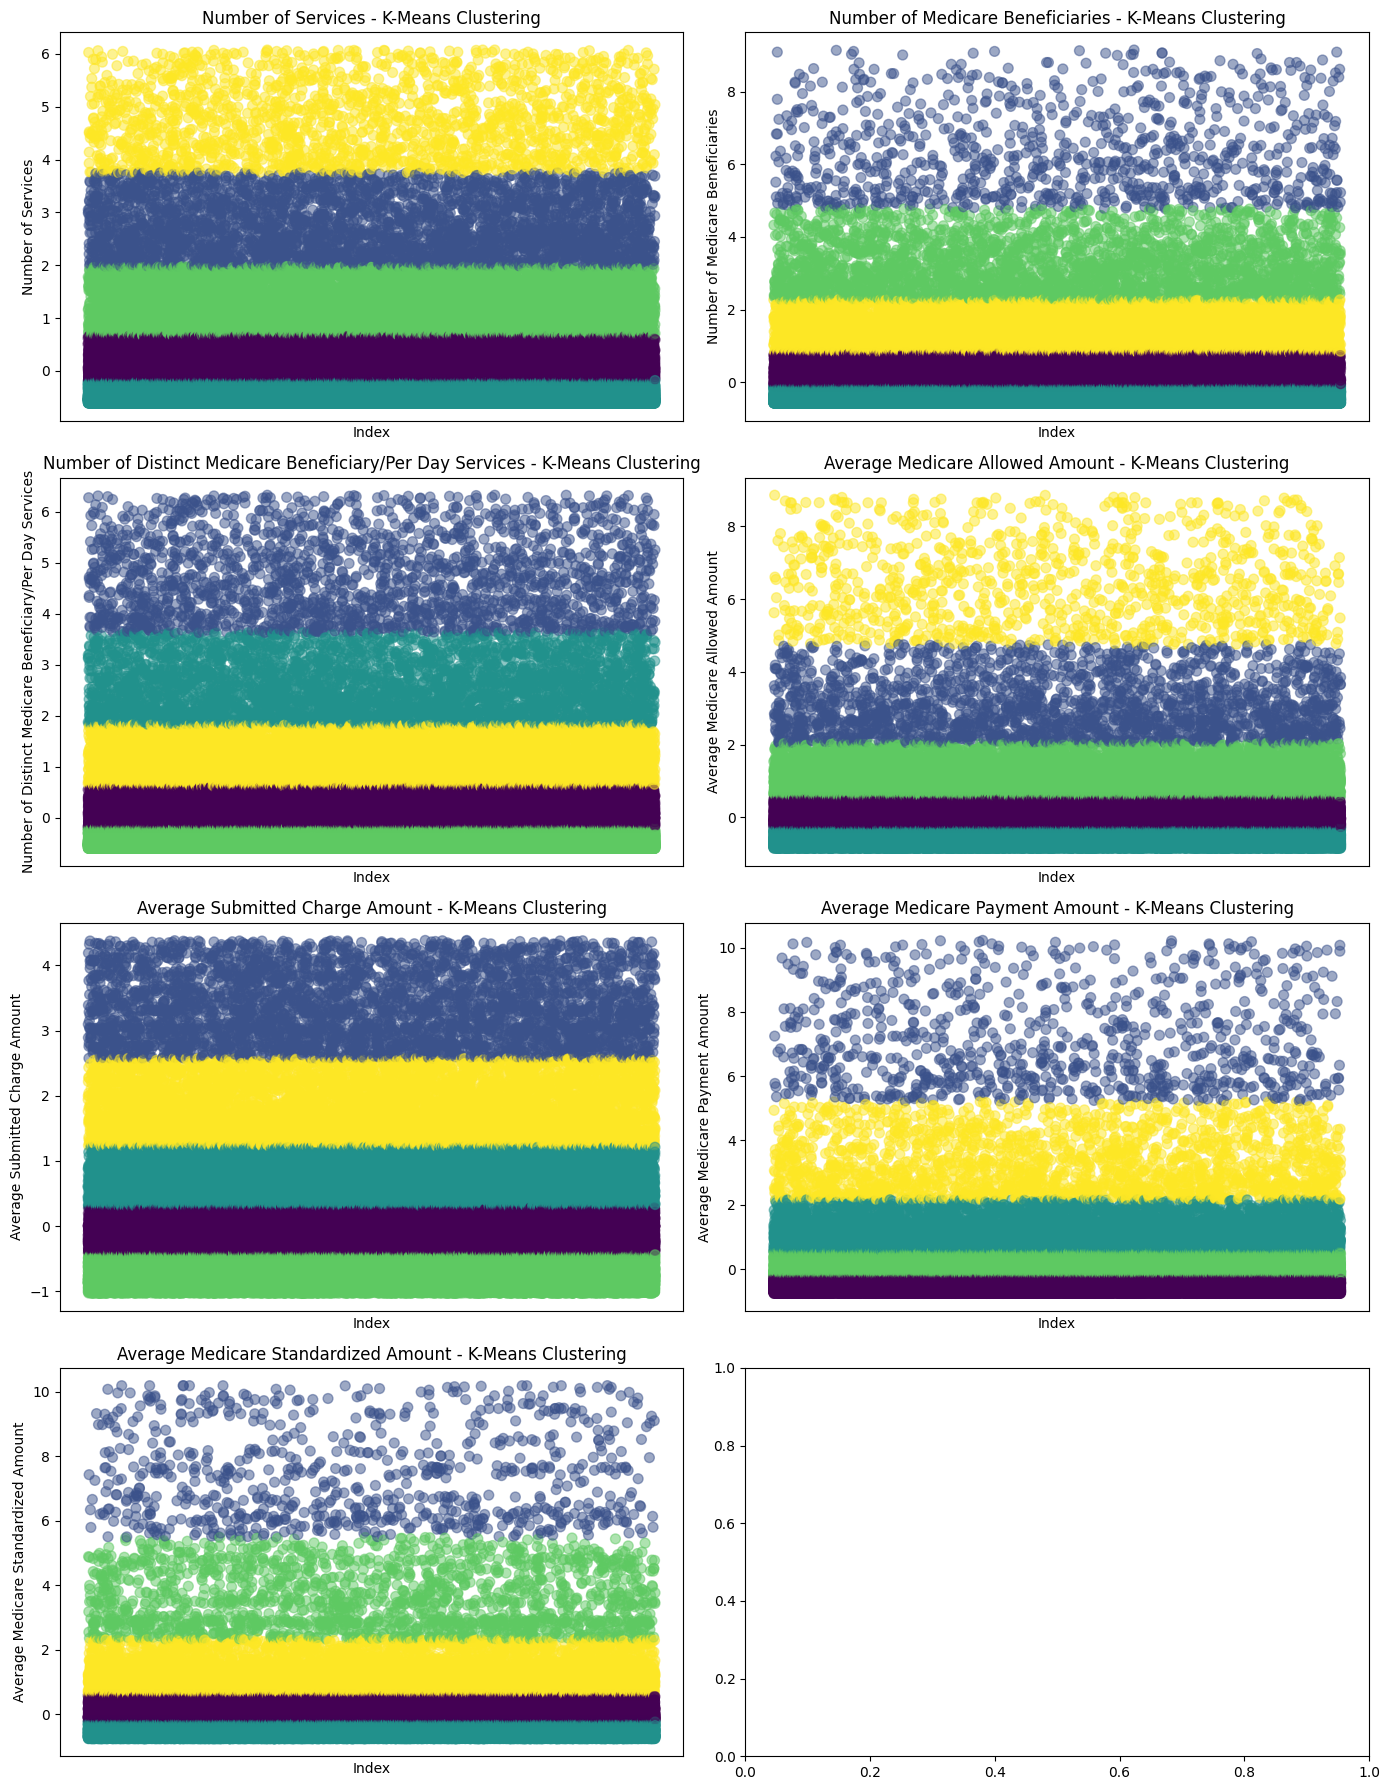

In [12]:
# Define the number of clusters (K)
k = 5

# Create subplots for each numeric column
fig, axes = plt.subplots(4, 2, figsize=(14, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    # Perform K-Means clustering on the current column
    kmeans = KMeans(n_clusters=k, random_state=0)
    data['Cluster'] = kmeans.fit_predict(data[[col]])

    # Plot the column against its K-Means cluster assignments
    ax = axes[i]
    ax.scatter(data.index, data[col], c=data['Cluster'], s=50, alpha=0.5)
    ax.set_title(f'{col} - K-Means Clustering')
    ax.set_xlabel('Index')
    ax.set_ylabel(col)
    ax.set_xticks([])

plt.tight_layout()
plt.show()

DBSCAN Clustering

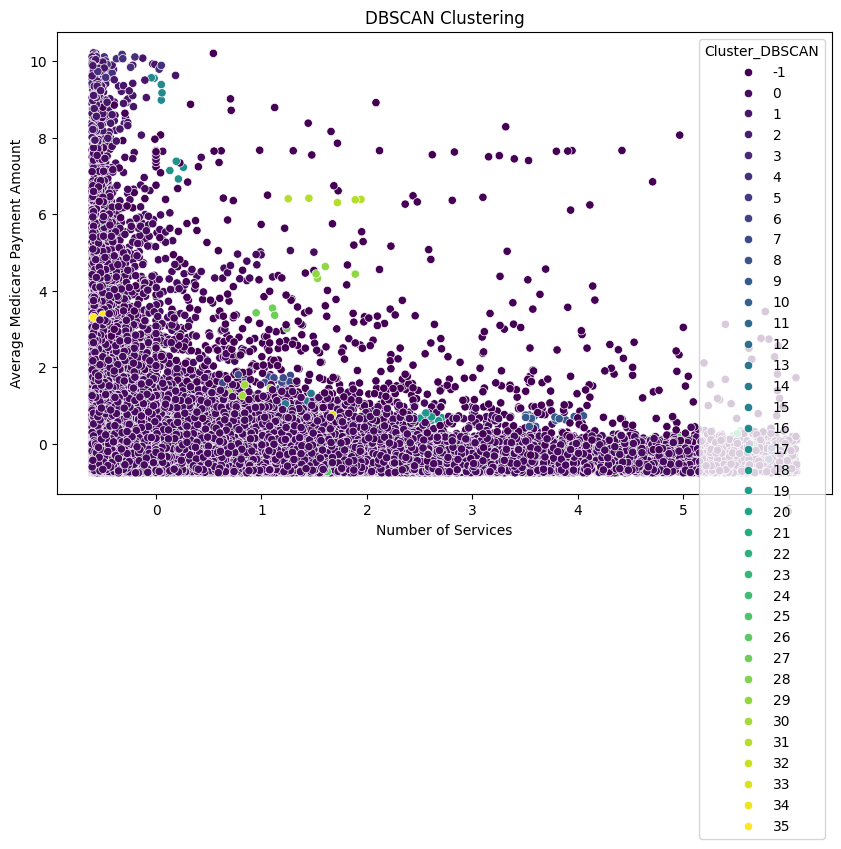

In [13]:
dbscan = DBSCAN(eps=0.5, min_samples=4)
data['Cluster_DBSCAN'] = dbscan.fit_predict(data[numeric_columns])

# Visualize DBSCAN clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Number of Services', y='Average Medicare Payment Amount',
                hue='Cluster_DBSCAN', palette='viridis', legend='full')
plt.title('DBSCAN Clustering')
plt.show()

Algo plot of DBSCAN

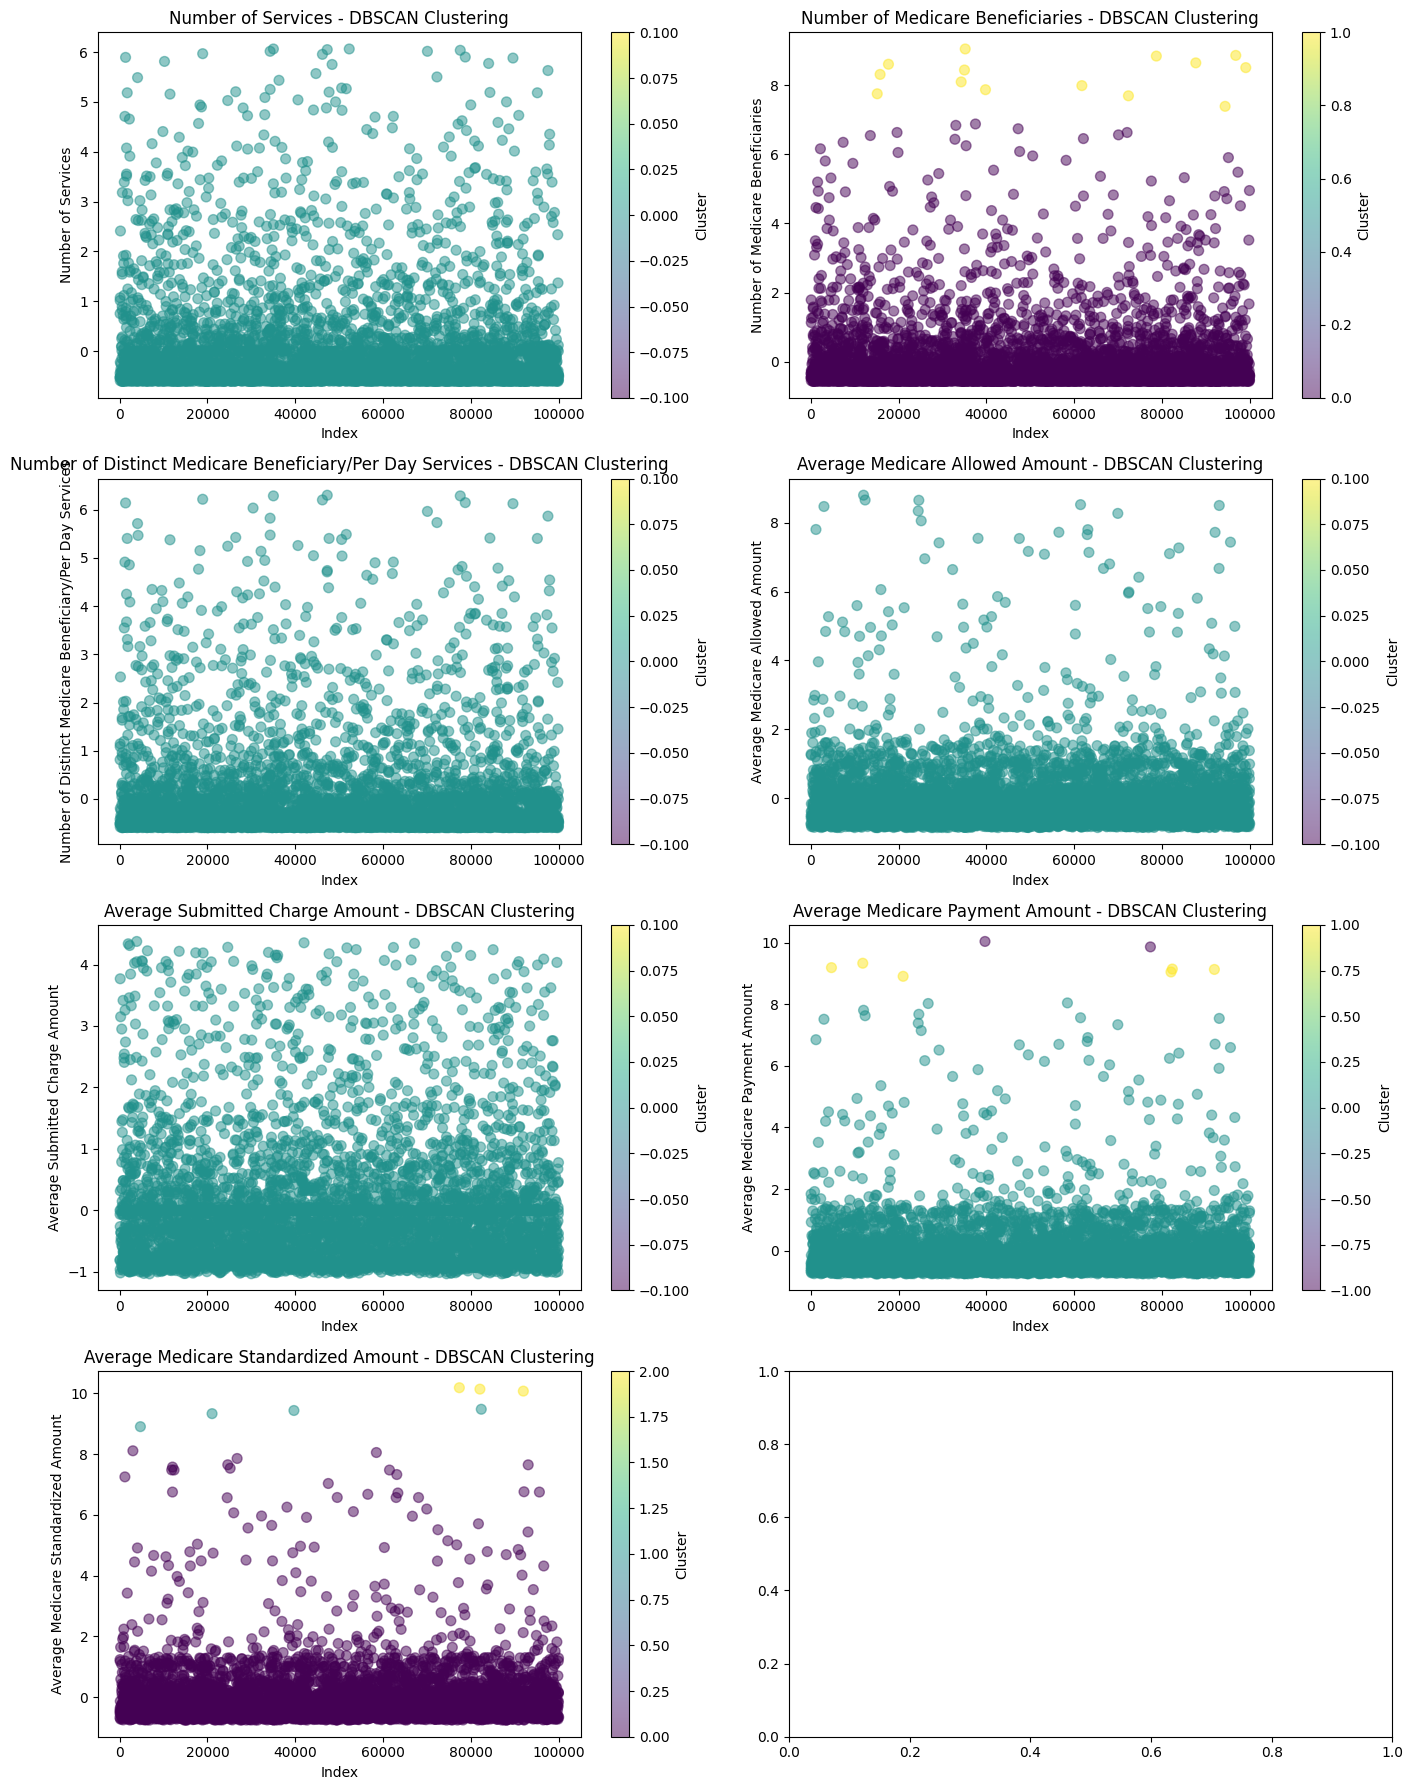

In [14]:
# Define the parameters for DBSCAN
eps = 0.5
min_samples = 3

# Sample the data for visualization (optional, for faster plotting)
data_sampled = data[numeric_columns].sample(n=5000, random_state=42)

# Create subplots for each numeric column
fig, axes = plt.subplots(4, 2, figsize=(14, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    # Perform DBSCAN clustering on the current column
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    data_sampled['Cluster'] = dbscan.fit_predict(data_sampled[[col]])

    # Plot the column against its DBSCAN cluster assignments
    ax = axes[i]
    scatter = ax.scatter(data_sampled.index, data_sampled[col], c=data_sampled['Cluster'], cmap='viridis', s=50, alpha=0.5)
    ax.set_title(f'{col} - DBSCAN Clustering')
    ax.set_xlabel('Index')
    ax.set_ylabel(col)

    # Add color bar to show cluster labels
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Cluster')

plt.tight_layout()
plt.show()